In [21]:
# You must learn the following libraries in this assignment.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import sklearn
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import itertools 

%matplotlib inline



In [22]:
# set PyTorch and python random seeds for repeated results.
torch.manual_seed(150)
random.seed(50)

In [23]:
# Training and test folder paths
train_data_path = "C:/Users/ASUS/PyTorch/Assignment/trainingset_DogCat"
test_data_path = "C:/Users/ASUS/PyTorch/Assignment/testset_DogCat"
# Transform images to tensor and normalize using ImageNet mean/std values;
# images are resized to image_sizeximage_sizex3(RGB) 
# Perform basic data augmentation (just random horizontal flip to showcase the concept)
image_size=120
train_image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Basic data augmentation
    transforms.ToTensor(),transforms.Resize((image_size,image_size)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
# For the validation/test images we only want to normalize and convert to tensor
test_image_transforms = transforms.Compose([
    transforms.ToTensor(),transforms.Resize((image_size,image_size)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225] )
    ])
# Training and test datasets
train_data = ImageFolder(root=train_data_path, transform=train_image_transforms)
test_data = ImageFolder(root=test_data_path, transform=test_image_transforms)
# Data loaders
batch_size=25
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True,  num_workers=4)
test_data_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)

In [24]:
# Define un-normalize function to reverse the normalization transformation used on the images
# We need to use this if we want to display any images later 
un_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Un-normalize an image, and change the shape to img
def tensor_to_image(image):
    return un_normalize(image).permute(1,2,0)

In [25]:
# Verify data size and shape
print("Train samples: ", len(train_data))
print("Test samples: ", len(test_data))
print("Train Labels: ", train_data.classes)
print("Test Labels: ", test_data.classes)
print("Train Labels-to-index mapping: ", train_data.class_to_idx)
print("Test Labels-to-index mapping: ", test_data.class_to_idx)
# Verify train/test data targets are balanced
print("Train data bincount of classes: ", torch.bincount(torch.tensor(train_data.targets)))
print("Test data bincount of classes: ", torch.bincount(torch.tensor(test_data.targets)))
#sample_img,sample_label=train_data[0]
sample_img,sample_label = next(iter(test_data))
print("Sample Image tensor size:", sample_img.shape)
print("Sample Label: ",sample_label)

# create reverse mapping dictionary for labels 
idx_to_label_mapping = {value:key for key,value in train_data.class_to_idx.items()}

Train samples:  7239
Test samples:  1806
Train Labels:  ['cats', 'dogs']
Test Labels:  ['cats', 'dogs']
Train Labels-to-index mapping:  {'cats': 0, 'dogs': 1}
Test Labels-to-index mapping:  {'cats': 0, 'dogs': 1}
Train data bincount of classes:  tensor([3580, 3659])
Test data bincount of classes:  tensor([893, 913])
Sample Image tensor size: torch.Size([3, 120, 120])
Sample Label:  0


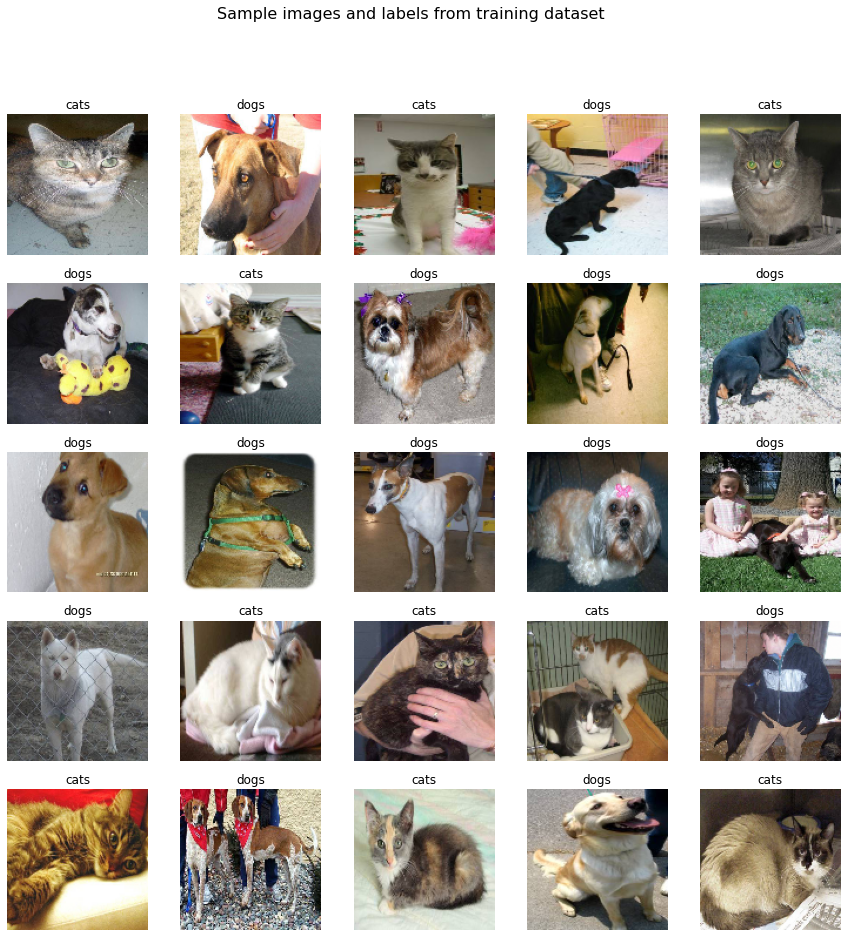

In [26]:
for batch in train_data_loader:
    images,labels = batch
    # Display 5x5 grid of random images + labels (data loader is shuffling)
        
    fig = plt.figure(figsize=(15,15))
    fig.suptitle("Sample images and labels from training dataset", fontsize=16)
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        plt.imshow(tensor_to_image(images[i]))
        plt.axis('off')
        label=idx_to_label_mapping[labels[i].item()]
        ax.set_title(label)
           
    plt.show()
    break # We only want to show a few images from the first batch

In [27]:
# Training function/loop
def train(model, optimizer, loss_fn, train_loader, val_loader, lr, epochs=10):
    
    batch_losses = []
    training_losses = []
    iters = []
    validation_losses = []
    validation_accuracies = []
    training_accuracies = []
    validation_loss=0.0
    validation_accuracy=0.0
    n = 0
    
    # Epochs loop...
    for epoch in range(epochs):
        training_loss = 0.0
        start = time.time()
        model.train() # Put model in 'training mode'
        
        # Train in batches
        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad() # Reset gradients
            output = model(images) # forward pass
            loss = loss_fn(output, labels) # Calculate loss
            
            loss.backward() # Calculate gradients
            #print(loss)
            optimizer.step() # Update weights

            training_loss += loss.data.item()
            batch_losses.append(loss.data.item())
                        
        # Model evaluation on full test set after all batches complete
        validation_loss, validation_accuracy, val_num_correct, val_num_examples = eval_model(model, loss_fn, val_loader)
        
        # Model evaluation on training set
        _, training_accuracy, train_num_correct, train_num_examples = eval_model(model, loss_fn, train_loader)
        
        # Calculate overall training and validation losses
        training_loss = training_loss / len(train_loader)
        
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)
        iters.append(n)
        n += 1

        end = time.time()
        print('Epoch: {}/{} Train Loss: {:.2f} Train Accuracy: {:.2f} Val loss: {:.2f} Val Accuracy: {:.2f} - {:.2f}secs'.format(
            epoch+1, epochs, training_loss, training_accuracy, validation_loss, validation_accuracy, end-start ))

    # Plot training curves
    plt.title("Training Loss per Batch (batch_size={} lr={})".format(batch_size,lr))
    batch_iters = range(len(batch_losses))
    plt.plot(batch_iters, batch_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Training Loss")
    plt.show()
    
    plt.title("Training Curve (batch_size={} lr={})".format(batch_size,lr))
    plt.plot(iters, training_losses, label="Train")
    plt.plot(iters, validation_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()
    
    plt.title("Training Curve (batch_size={} lr={})".format(batch_size,lr))
    plt.plot(iters, training_accuracies, label="Training Accuracy")
    plt.plot(iters, validation_accuracies, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [28]:
def eval_model(model, loss_fn, data_loader):
    # Model evaluation after all batches complete
    model.eval() # put model in 'eval' mode
    num_correct = 0
    num_examples = 0
    average_loss = 0.0

    with torch.no_grad(): # evaluating so no need to do any autograd
        for batch in data_loader:
            images, labels = batch
            predictions = model(images) # get predictions

            loss = loss_fn(predictions, labels)
            average_loss += loss.data.item()

            prediction_labels = torch.argmax(predictions, dim=1) # vector of index positions [2,0,1,2,2,1,2,0]
            correct = torch.eq(prediction_labels, labels) # Vector of T/F correct predictions [T,T,F]

            num_correct += torch.sum(correct).item() # Count of number correct in this batch - 2
            num_examples += labels.shape[0] # number of items in this batch

    average_loss = average_loss / len(data_loader)
    accuracy = num_correct / num_examples
    return average_loss, accuracy, num_correct, num_examples

In [29]:
def show_model_summary(name, model, data_loader, show_samples=False):
    model.eval() # put model in 'eval' mode
    all_predictions=[]
    groundtruth_labels=[]
    all_predicted_correct_labels=[]
    all_predicted_incorrect_groundtruth_labels=[]
    all_predicted_incorrect_predicted_labels=[]
    all_predicted_correct=torch.Tensor([])
    all_predicted_incorrect=torch.Tensor([])
    
    # Disable PyTorch gradient tracking for evaluation - performance & memory boost
    with torch.no_grad():
        for batch in data_loader:
            images, labels = batch
            predictions = model(images) # get predictions - this is output from network
            softmax_predictions = F.softmax(predictions, dim=1) # vector of prediction probabilities [0.2,0.3,0.5]
            prediction_labels = torch.argmax(softmax_predictions, dim=1) # vector of index positions [2,0,1]
            
            # Store the correct and incorrect predictions and labels so that we can show some examples later
            predicted_correct = images[prediction_labels.eq(labels)]
            predicted_incorrect = images[prediction_labels.ne(labels)]
            all_predicted_correct = torch.cat((all_predicted_correct, predicted_correct), dim=0)
            all_predicted_incorrect = torch.cat((all_predicted_incorrect,predicted_incorrect), dim=0)
            all_predicted_correct_labels.extend(labels[prediction_labels.eq(labels)].tolist())
            all_predicted_incorrect_groundtruth_labels.extend(labels[prediction_labels.ne(labels)].tolist())
            all_predicted_incorrect_predicted_labels.extend(prediction_labels[prediction_labels.ne(labels)].tolist())

            # Add batch predictions to full list - use extend vs append here so that each element is added to list
            all_predictions.extend(prediction_labels.tolist())
            groundtruth_labels.extend(labels.tolist())
    
    # We now have an array of all predictions (as label indices) and also all the ground truth labels
    print('*' * 40)
    print("Model Summary for ", name)
    print("Model Accuracy: {:.2f}%".format(sklearn.metrics.accuracy_score(groundtruth_labels, all_predictions)*100))
    
    #print("Confusion Matrix:")
    #print(confusion_matrix(groundtruth_labels, all_predictions))
    cm = confusion_matrix(groundtruth_labels, all_predictions)
    plot_confusion_matrix(cm, train_data.classes, title='Confusion Matrix - '+name)
    
    print("Classification Report:")
    print(classification_report(groundtruth_labels, all_predictions, target_names=train_data.classes))
    
    # Show a few examples of classified images
    if (show_samples):
        fig = plt.figure(figsize=(10,10))
        fig.suptitle("Correctly classified images from TEST dataset", fontsize=16)
        for i in range(10):
            ax = plt.subplot(5, 5, i+1)
            plt.imshow(tensor_to_image(all_predicted_correct[i]))
            plt.axis('off')
            label=idx_to_label_mapping[all_predicted_correct_labels[i]]
            ax.set_title(label)
            ax.title.set_color('green')
        plt.show()
        
        fig = plt.figure(figsize=(10,10))
        fig.suptitle("Incorrectly classified images from TEST dataset", fontsize=16)
        for i in range(10):
            ax = plt.subplot(5, 5, i+1)
            plt.imshow(tensor_to_image(all_predicted_incorrect[i]))
            plt.axis('off')
            label='{} ({})'.format(
                idx_to_label_mapping[all_predicted_incorrect_predicted_labels[i]],
                idx_to_label_mapping[all_predicted_incorrect_groundtruth_labels[i]])
            ax.set_title(label)
            ax.title.set_color('red')
        plt.show()

In [30]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Inspired by deep learning training video on DeepLizard.com
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks= np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    
    color_threshold = cm.max()/2. # Should the text be black or white within each cell?
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]), 
                 horizontalalignment='center', 
                 color='black' if cm[i,j] < color_threshold else 'white')
            
    axes = plt.gca()
    plt.xlim([-0.5,len(classes)-0.5])
    plt.ylim([-0.5,len(classes)-0.5])
    axes.invert_yaxis() # We want top left to bottom right diagonal of matchin labels
    plt.show()

In [31]:
class FullyConnectedModel(nn.Module):
    def __init__(self, layer1_nodes=100, layer2_nodes=50, use_dropout=False):
        super(FullyConnectedModel, self).__init__()
        
        self.layer1_nodes = layer1_nodes
        self.layer2_nodes = layer2_nodes
        self.use_dropout = use_dropout
        
        
        self.fc1 = nn.Linear(image_size * image_size * 3, layer1_nodes) # 100 node hidden layer
        self.fc2 = nn.Linear(layer1_nodes, layer2_nodes) # 50 node hidden layer
        self.out = nn.Linear(layer2_nodes, 2) # 3 output channels for 2 x classification labels
        self.dropout = nn.Dropout()
        
    def forward(self, img):
        # Input Layer - flatten the image
        x = img.view(-1, image_size * image_size * 3) 
        
        # Hidden layer 1
        x = F.relu(self.fc1(x))
        
        if self.use_dropout:
            x = self.dropout(x)
        
        # Hidden later 2
        x = F.relu(self.fc2(x))
        
        if self.use_dropout:
            x = self.dropout(x)
        
        # Output layer - do not apply softmax here as we are using CrossEntropyLoss where softmax is implicit
        x = self.out(x)
        
        return x

# Show instance details
print(FullyConnectedModel())

FullyConnectedModel(
  (fc1): Linear(in_features=43200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Before Training: Validation loss: 0.69 Accuracy: 0.52 (946/1806)
Epoch: 1/10 Train Loss: 0.67 Train Accuracy: 0.65 Val loss: 0.65 Val Accuracy: 0.62 - 56.73secs
Epoch: 2/10 Train Loss: 0.63 Train Accuracy: 0.67 Val loss: 0.64 Val Accuracy: 0.62 - 61.89secs
Epoch: 3/10 Train Loss: 0.60 Train Accuracy: 0.69 Val loss: 0.62 Val Accuracy: 0.64 - 61.80secs
Epoch: 4/10 Train Loss: 0.58 Train Accuracy: 0.70 Val loss: 0.64 Val Accuracy: 0.64 - 60.09secs
Epoch: 5/10 Train Loss: 0.57 Train Accuracy: 0.71 Val loss: 0.64 Val Accuracy: 0.63 - 64.59secs
Epoch: 6/10 Train Loss: 0.54 Train Accuracy: 0.75 Val loss: 0.65 Val Accuracy: 0.65 - 57.38secs
Epoch: 7/10 Train Loss: 0.53 Train Accuracy: 0.76 Val loss: 0.65 Val Accuracy: 0.65 - 63.46secs
Epoch: 8/10 Train Loss: 0.50 Train Accuracy: 0.76 Val loss: 0.68 Val Accuracy: 0.63 - 58.15secs
Epoch: 9/10 Train Loss: 0.48 Train Accuracy: 0.82 Val loss: 0.66 Val Accuracy: 0.65 - 62.76secs
Epoch: 10/10 Train Loss: 0.46 Train Accuracy: 0.77 Val loss: 0.78 Val A

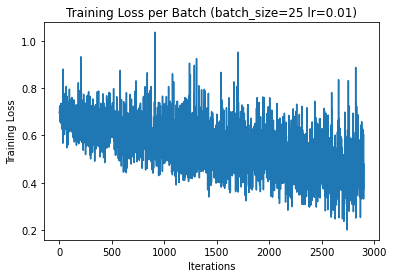

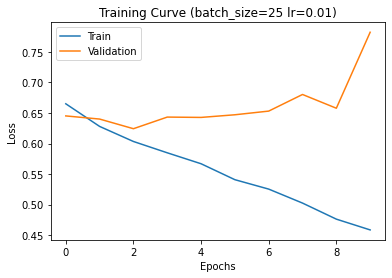

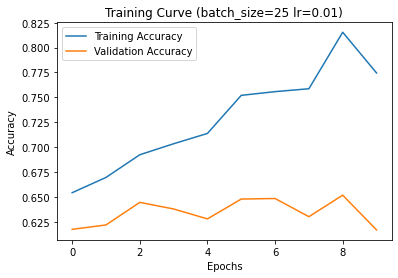

In [32]:
LR=0.01  # Learning rate; 0.001
EPOCHS=10

# Initialize model, optimizer and loss function
model = FullyConnectedModel()
optimizer = optim.SGD(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

#Sanity check to ensure model cannot predict anything before training (circa 33% accuracy expected here)
validation_loss, accuracy, num_correct, num_examples = eval_model(model, loss_fn, test_data_loader)
print('Before Training: Validation loss: {:.2f} Accuracy: {:.2f} ({}/{})'.format(
            validation_loss, accuracy, num_correct, num_examples ))

train(model, optimizer, loss_fn, train_data_loader, test_data_loader, lr=LR, epochs=EPOCHS)

****************************************
Model Summary for  Fully Connected Model - Training Data
Model Accuracy: 77.48%


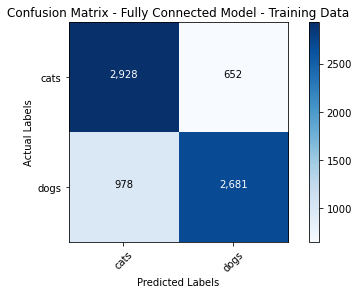

Classification Report:
              precision    recall  f1-score   support

        cats       0.75      0.82      0.78      3580
        dogs       0.80      0.73      0.77      3659

    accuracy                           0.77      7239
   macro avg       0.78      0.78      0.77      7239
weighted avg       0.78      0.77      0.77      7239

****************************************
Model Summary for  Fully Connected Model - Test Data
Model Accuracy: 61.68%


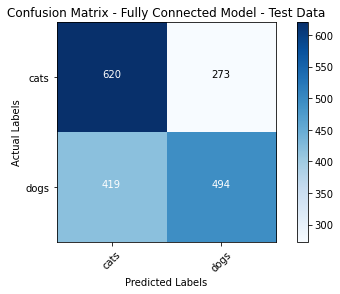

Classification Report:
              precision    recall  f1-score   support

        cats       0.60      0.69      0.64       893
        dogs       0.64      0.54      0.59       913

    accuracy                           0.62      1806
   macro avg       0.62      0.62      0.61      1806
weighted avg       0.62      0.62      0.61      1806



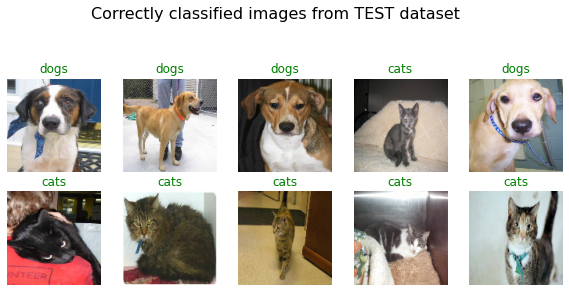

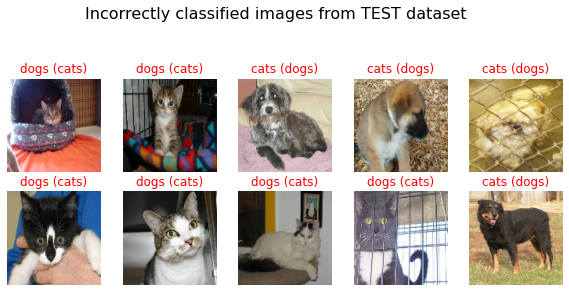

In [33]:
show_model_summary("Fully Connected Model - Training Data", model, train_data_loader)
show_model_summary("Fully Connected Model - Test Data", model, test_data_loader, show_samples=True)

In [34]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size=3, conv1_channels=16, conv2_channels=32, linear1_nodes=128, linear2_nodes=64):
        super(CNNModel, self).__init__()
        
        self.kernel_size = kernel_size
        self.conv1_channels = conv1_channels
        self.conv2_channels = conv2_channels
        self.linear1_nodes = linear1_nodes
        self.linear2_nodes = linear2_nodes
        self.classifier_in_features = self.calculate_conv_output_size()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.conv1_channels, kernel_size=self.kernel_size, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=self.conv1_channels, out_channels=self.conv2_channels, kernel_size=self.kernel_size, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(self.conv2_channels * self.classifier_in_features ** 2, self.linear1_nodes), # 32 x 32 x 22 - using in_features so that we can change kernel_size
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(self.linear1_nodes, self.linear2_nodes),
            nn.ReLU(),
            nn.Linear(self.linear2_nodes, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        #print("After features:",x.shape)
        x = torch.flatten(x, 1)
        #print("After flatten:",x.shape)
        x = self.classifier(x)
        #return F.log_softmax(x, dim=1)
        return x
    
    def calculate_size_after_convolution(self,n,f,p,s):
        o = ((n-f+(2*p))/s)+1
        return math.floor(o)
    
    # Dynamically calculate the size of the output after the 2 x convolution layers including max pooling
    # This allows us to expermient with differing kernel sizes
    def calculate_conv_output_size(self):
        after_conv1=self.calculate_size_after_convolution(120,self.kernel_size,0,1)
        after_pool1=self.calculate_size_after_convolution(after_conv1,2,0,2)
        after_conv2=self.calculate_size_after_convolution(after_pool1,self.kernel_size,0,1)
        after_pool2=self.calculate_size_after_convolution(after_conv2,2,0,2)
        return after_pool2
    
cnn_model = CNNModel()
print(cnn_model)
#cnn_model(torch.randn(1,3,96,96))

CNNModel(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=25088, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)


Before Training: Validation loss: 0.69 Accuracy: 0.49 (893/1806)
Epoch: 1/10 Train Loss: 0.65 Train Accuracy: 0.72 Val loss: 0.58 Val Accuracy: 0.71 - 69.13secs
Epoch: 2/10 Train Loss: 0.56 Train Accuracy: 0.77 Val loss: 0.54 Val Accuracy: 0.75 - 68.83secs
Epoch: 3/10 Train Loss: 0.52 Train Accuracy: 0.79 Val loss: 0.53 Val Accuracy: 0.75 - 70.77secs
Epoch: 4/10 Train Loss: 0.47 Train Accuracy: 0.81 Val loss: 0.50 Val Accuracy: 0.76 - 71.34secs
Epoch: 5/10 Train Loss: 0.45 Train Accuracy: 0.83 Val loss: 0.50 Val Accuracy: 0.76 - 72.11secs
Epoch: 6/10 Train Loss: 0.42 Train Accuracy: 0.86 Val loss: 0.49 Val Accuracy: 0.78 - 71.66secs
Epoch: 7/10 Train Loss: 0.39 Train Accuracy: 0.87 Val loss: 0.49 Val Accuracy: 0.79 - 75.82secs
Epoch: 8/10 Train Loss: 0.36 Train Accuracy: 0.90 Val loss: 0.47 Val Accuracy: 0.79 - 76.47secs
Epoch: 9/10 Train Loss: 0.35 Train Accuracy: 0.90 Val loss: 0.47 Val Accuracy: 0.79 - 73.46secs
Epoch: 10/10 Train Loss: 0.32 Train Accuracy: 0.92 Val loss: 0.48 Val A

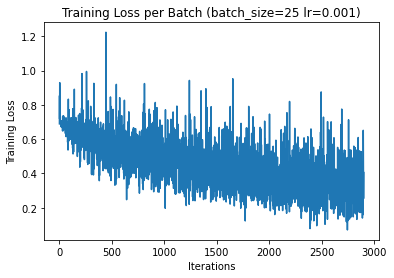

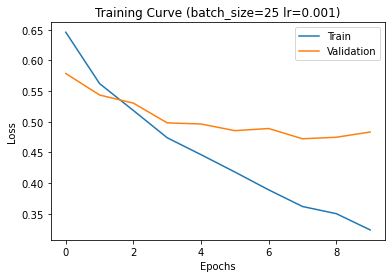

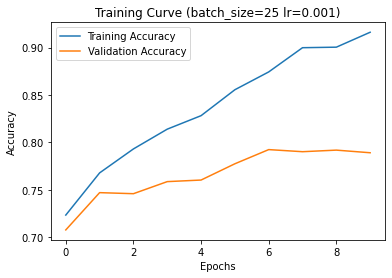

In [37]:
LR=0.001
EPOCHS=10

# Initialize model, optimizer and loss function
model = CNNModel()
optimizer = optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.CrossEntropyLoss()

# Sanity check the model (with random initialization) before any training occurs
validation_loss, accuracy, num_correct, num_examples = eval_model(model, loss_fn, test_data_loader)
print('Before Training: Validation loss: {:.2f} Accuracy: {:.2f} ({}/{})'.format(
            validation_loss, accuracy, num_correct, num_examples ))

# Train the model
train(model, optimizer, loss_fn, train_data_loader, test_data_loader, lr=LR, epochs=EPOCHS)

****************************************
Model Summary for  Fully Connected Model - Training Data
Model Accuracy: 91.61%


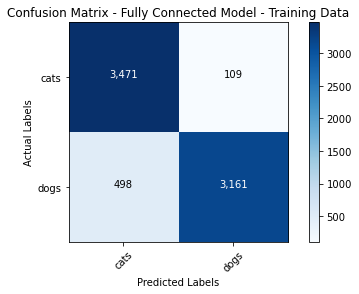

Classification Report:
              precision    recall  f1-score   support

        cats       0.87      0.97      0.92      3580
        dogs       0.97      0.86      0.91      3659

    accuracy                           0.92      7239
   macro avg       0.92      0.92      0.92      7239
weighted avg       0.92      0.92      0.92      7239

****************************************
Model Summary for  Fully Connected Model - Test Data
Model Accuracy: 78.90%


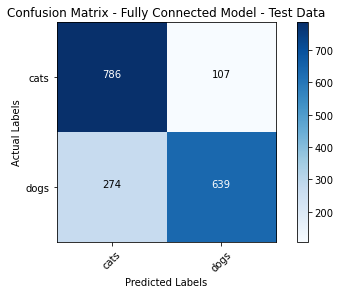

Classification Report:
              precision    recall  f1-score   support

        cats       0.74      0.88      0.80       893
        dogs       0.86      0.70      0.77       913

    accuracy                           0.79      1806
   macro avg       0.80      0.79      0.79      1806
weighted avg       0.80      0.79      0.79      1806



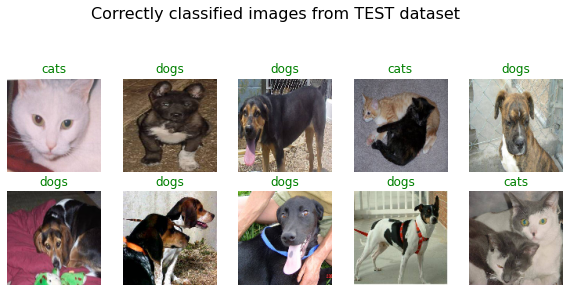

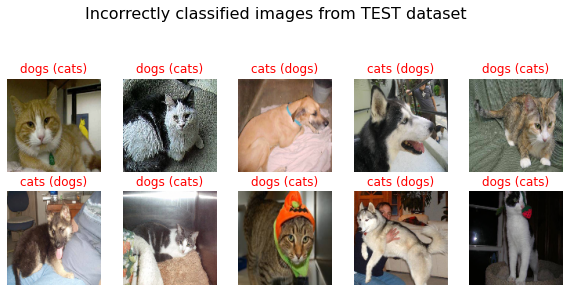

In [38]:
show_model_summary("Fully Connected Model - Training Data", model, train_data_loader)
show_model_summary("Fully Connected Model - Test Data", model, test_data_loader, show_samples=True)